In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [4]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
import pandas as pd
import torch

In [15]:
DATA_DIR = '../../datasets/Textual/Abt-Buy/'
test_df = pd.read_csv(DATA_DIR+'merged_test.csv')
test_df[test_df.label==1].to_csv(DATA_DIR+'test_positives.csv',index=False)
test_df[test_df.label==0].to_csv(DATA_DIR+'test_negatives.csv',index=False)

In [40]:
train_df = pd.read_csv(DATA_DIR+'merged_train.csv')
valid_df = pd.read_csv(DATA_DIR+'merged_validation.csv')

In [41]:
allSamples = pd.concat([train_df,valid_df,test_df],ignore_index=True)
allSamples[allSamples.label==1].to_csv(DATA_DIR+'positives.csv',index=False)
allSamples[allSamples.label==0].to_csv(DATA_DIR+'negatives.csv',index=False)

## Dataset creation with hybrid model

In [22]:
attributes = ['name','description','price']

In [10]:
hybrid_model = dm.MatchingModel(attr_summarizer='hybrid')
hybrid_model.load_state('../../models/abtbuy_hybrid.pth')
hybrid_model = hybrid_model.cuda()

In [11]:
testneg = return_layer_input(hybrid_model,hybrid_model.classifier,
                             '../../datasets/Textual/Abt-Buy','test_negatives')


Reading and processing data from "../../datasets/Textual/Abt-Buy/test_negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [17]:
testpos = return_layer_input(hybrid_model,hybrid_model.classifier,
                             DATA_DIR,'test_positives')


Reading and processing data from "../../datasets/Textual/Abt-Buy//test_positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [44]:
positives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Textual/Abt-Buy','positives')


Reading and processing data from "../../datasets/Textual/Abt-Buy/positives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [46]:
negatives = return_layer_input(hybrid_model,hybrid_model.classifier,
                               '../../datasets/Textual/Abt-Buy/','negatives')


Reading and processing data from "../../datasets/Textual/Abt-Buy//negatives.csv"
0% [############################# ] 100% | ETA: 00:00:00

In [47]:
## Basta scegliere un campione a caso
classifier_len = len(list(testneg.values())[0])
attribute_len = int(classifier_len/len(attributes))

## Ri discovery

### Negatives

In [23]:
testneg_ri,testneg_ri_norms = computeRi(hybrid_model.classifier,attributes,testneg,0)
torch.save(testneg_ri,'experiments_results/testneg_ri_hybrid.pt')


 20%|██        | 344/1710 [00:22<01:14, 18.44it/s]


 41%|████▏     | 706/1710 [00:43<01:06, 15.20it/s]


 62%|██████▏   | 1066/1710 [01:05<00:36, 17.88it/s]


 82%|████████▏ | 1408/1710 [01:27<00:17, 16.85it/s]


100%|██████████| 1710/1710 [01:46<00:00, 16.08it/s]


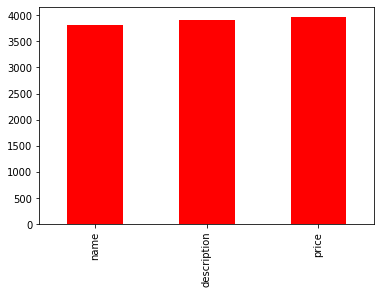

In [25]:
testneg_ri_norms.drop(['sample_id'],axis=1).sum(numeric_only=True).plot.bar(color='red')

In [27]:
testneg_ri_norms.to_csv('experiments_results/testneg_ri_norms.csv',index=False)

### Positives

In [28]:
testpos_ri,testpos_ri_norms = computeRi(hybrid_model.classifier,attributes,testpos,1)
torch.save(testpos_ri,'experiments_results/testpos_ri_hybrid.pt')


100%|██████████| 206/206 [00:20<00:00,  9.88it/s]


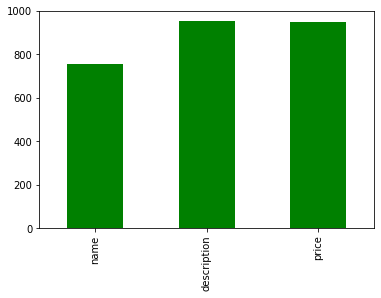

In [29]:
testpos_ri_norms.drop(['sample_id'],axis=1).sum().plot.bar(color='green')

In [25]:
testpos_ri_norms.to_csv('experiment_results/testpos_ri_norms.csv',index=False)

## Nearest neighbors discovery

In [37]:
from utils.distance_measures import nearestNeighborOnAttributes

In [21]:
testneg_ri = torch.load('experiment_results/testneg_ri_hybrid.pt')
testpos_ri = torch.load('experiment_results/testpos_ri_hybrid.pt')

In [48]:
negatives_closer_vectors_df = nearestNeighborOnAttributes(testneg,testneg_ri,positives,attributes,attribute_len,
                                                         min_similarity=-1)


100%|██████████| 1710/1710 [00:02<00:00, 606.57it/s]


In [50]:
negatives_closer_vectors_df.to_csv('experiments_results/testnegNN_hybrid.csv',index=False)

In [51]:
positives_closer_vectors_df = nearestNeighborOnAttributes(testpos,testpos_ri,negatives,
                                                                      attributes,attribute_len,
                                                                       min_similarity=-1)


100%|██████████| 206/206 [00:01<00:00, 192.34it/s]


In [52]:
positives_closer_vectors_df.to_csv('experiments_results/testposNN_hybrid.csv',index=False)

## Correct rankings

In [53]:
from utils.distance_measures import smallestDistanceOnAttributes

In [54]:
testpos_nn_distances = smallestDistanceOnAttributes(testpos,testpos_ri,
                                                       negatives,attributes,attribute_len)


100%|██████████| 206/206 [00:01<00:00, 166.17it/s]


In [55]:
testneg_nn_distances = smallestDistanceOnAttributes(testneg,testneg_ri,
                                                        positives,attributes,attribute_len)


100%|██████████| 1710/1710 [00:02<00:00, 639.52it/s]


In [56]:
correct_rankings_testneg = pd.DataFrame(testneg_ri_norms.values/testneg_nn_distances.values, 
                                        columns= testneg_ri_norms.columns, index= testneg_ri_norms.index)

In [57]:
correct_rankings_testpos = pd.DataFrame(testpos_ri_norms.values/testpos_nn_distances.values, 
                                        columns= testpos_ri_norms.columns, index= testpos_ri_norms.index)

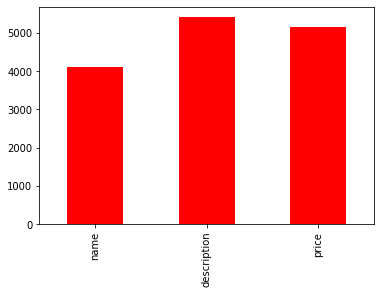

In [58]:
correct_rankings_testneg.drop(['sample_id'],axis=1).sum().plot.bar(color='red')

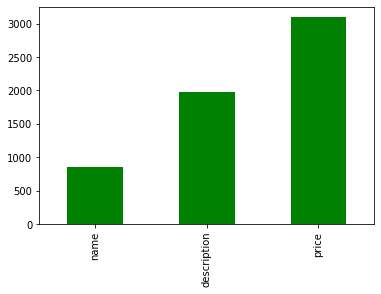

In [59]:
correct_rankings_testpos.drop(['sample_id'],axis=1).sum().plot.bar(color='green')